In [9]:
import sys
sys.path.append("../")

import math
import torch
import torch_geometric as pyg
import numpy as np
from models.LASE_unshared_normalized import LASE 
from models.RDPG_GD import RDPG_GD_Armijo, coordinate_descent
from models.SVD_truncate import embed_scipy
from models.bigbird_attention import big_bird_attention
from graspologic.embed import AdjacencySpectralEmbed 
from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph, erdos_renyi_graph
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from numpy import random
import time
from networkx import watts_strogatz_graph
from torch_geometric.utils.convert import from_networkx
from training.get_init import get_x_init
from scipy.stats import sem
import timeit

In [6]:
torch.manual_seed(42)
d = 5
gd_steps = 5
device = 'cuda'

# lase_full = LASE(d, d, gd_steps)
# lase_full.load_state_dict(torch.load('../saved_models/lase_unshared_d5_normalized_unbalanced.pt'))
# lase_full.to(device)
# lase_full.eval()

# lase_ER05 = LASE(d, d, gd_steps)
# lase_ER05.load_state_dict(torch.load('../saved_models/lase_unshared_d5_normalized_unbalanced_ER05.pt'))
# lase_ER05.to(device)
# lase_ER05.eval()

# lase_WS_03_01 = LASE(d, d, gd_steps)
# lase_WS_03_01.load_state_dict(torch.load('../saved_models/lase_unshared_d5_normalized_unbalanced_WS_100_01.pt'))
# lase_WS_03_01.to(device)
# lase_WS_03_01.eval()

# lase_WS_01_01 = LASE(d, d, gd_steps)
# lase_WS_01_01.load_state_dict(torch.load('../saved_models/lase_unshared_d5_normalized_unbalanced_WS_35_01.pt'))
# lase_WS_01_01.to(device)
# lase_WS_01_01.eval()

# lase_BB_01_002 = LASE(d, d, gd_steps)
# lase_BB_01_002.load_state_dict(torch.load('../saved_models/lase_unshared_d5_normalized_unbalanced_BB_01_002.pt'))
# lase_BB_01_002.to(device)
# lase_BB_01_002.eval()

def measure_execution_time(func, *args, loops=10, repetitions=10):
    times = np.zeros(repetitions)
    for i in range(repetitions):
        loop_time = timeit.timeit(lambda: func(*args), number=loops)
        times[i] = loop_time / loops
    best_time = np.mean(times)
    mean_time = np.mean(times)
    stderr = sem(times)  
    return best_time, mean_time, stderr

p = [
    [0.9, 0.1, 0.2, 0.2, 0.1],
    [0.1, 0.8, 0.1, 0.1, 0.2],
    [0.2, 0.1, 0.7, 0.2, 0.1],
    [0.2, 0.1, 0.2, 0.8, 0.2],
    [0.1, 0.2, 0.1, 0.2, 0.9],
]

nodes = np.arange(5,55,5)*100

# SVD

In [10]:
svd_exec_time = np.zeros((nodes.shape[0],2))

for i, num_nodes in enumerate(nodes):
    print(num_nodes)
    n = [int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5)]
    edge_index = stochastic_blockmodel_graph(n, p)
    best_time, mean_time, std_time = measure_execution_time(embed_scipy, edge_index, d, device)
    svd_exec_time[i]=[mean_time, std_time]
    print(f"Best execution time over 10 repetitions: {best_time:.8f} seconds")
    
with open('./results/svd_performance.pkl', 'wb') as f:
    pickle.dump(svd_exec_time, f)
print(svd_exec_time)

500
Best execution time over 10 repetitions: 0.14924933 seconds
1000
Best execution time over 10 repetitions: 0.21725525 seconds
1500
Best execution time over 10 repetitions: 0.27809597 seconds
2000
Best execution time over 10 repetitions: 0.32707174 seconds
2500
Best execution time over 10 repetitions: 0.42246012 seconds
3000
Best execution time over 10 repetitions: 0.48877824 seconds
3500
Best execution time over 10 repetitions: 0.58557303 seconds
4000
Best execution time over 10 repetitions: 0.66652275 seconds
4500
Best execution time over 10 repetitions: 0.76601891 seconds
5000
Best execution time over 10 repetitions: 0.91964983 seconds
[[0.14924933 0.00418499]
 [0.21725525 0.00928223]
 [0.27809597 0.01386187]
 [0.32707174 0.00831704]
 [0.42246012 0.01574316]
 [0.48877824 0.01256507]
 [0.58557303 0.01264761]
 [0.66652275 0.01300103]
 [0.76601891 0.01489261]
 [0.91964983 0.01295524]]


In [11]:
print(svd_exec_time)

[[0.14924933 0.00418499]
 [0.21725525 0.00928223]
 [0.27809597 0.01386187]
 [0.32707174 0.00831704]
 [0.42246012 0.01574316]
 [0.48877824 0.01256507]
 [0.58557303 0.01264761]
 [0.66652275 0.01300103]
 [0.76601891 0.01489261]
 [0.91964983 0.01295524]]


# Coordinate GD

In [12]:
cgd_exec_time = np.zeros((nodes.shape[0],2))

for i, num_nodes in enumerate(nodes):
    print(num_nodes)
    n = [int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5)]
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
    best_time, mean_time, std_time = measure_execution_time(coordinate_descent, edge_index, mask, d, device)
    cgd_exec_time[i]=[mean_time, std_time]
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")

with open('./results/coord_gd_performance.pkl', 'wb') as f:
    pickle.dump(cgd_exec_time, f)

500


/home/sofia/lase/repo2/LASE/notebooks/../models/RDPG_GD.py:102: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  X[i,:] = torch.tensor(solve_linear_system(R,(A[i,:]@X).T,X[i,:]), device=device)
/home/sofia/lase/repo2/LASE/notebooks/../models/RDPG_GD.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X[i,:] = torch.tensor(solve_linear_system(R,(A[i,:]@X).T,X[i,:]), device=device)


Best execution time over 5 repetitions: 0.62606275 seconds
1000


AttributeError: module 'torch.linalg' has no attribute 'cg'

# LASE Full

In [ ]:
lase_full_exec_time = np.zeros((nodes.shape[0],2))

for i, num_nodes in enumerate(nodes):
    print(num_nodes)
    n = [int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5)]
    x = torch.rand((num_nodes, d)).to(device)
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
    mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
    best_time, mean_time, std_time = measure_execution_time(lase_full, x, edge_index, edge_index_2, mask)
    lase_full_exec_time[i]=[mean_time, std_time]
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")
    
with open('./results/lase_full_performance.pkl', 'wb') as f:
    pickle.dump(lase_full_exec_time, f)

# LASE ER 05

In [8]:
lase_ER05_exec_time = np.zeros((nodes.shape[0],2))

for i, num_nodes in enumerate(nodes):
    print(num_nodes)
    n = [int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5)]
    x = torch.rand((num_nodes, d)).to(device)
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    ER05 = erdos_renyi_graph(num_nodes, 0.5, directed=False).to(device)
    mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
    best_time, mean_time, std_time = measure_execution_time(lase_ER05, x, edge_index, ER05, mask)
    lase_ER05_exec_time[i]=[mean_time, std_time]
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")
    
with open('./results/lase_ER05_performance.pkl', 'wb') as f:
    pickle.dump(lase_ER05_exec_time, f)

500
Best execution time over 5 repetitions: 0.01683839 seconds
1000
Best execution time over 5 repetitions: 0.04160210 seconds
1500
Best execution time over 5 repetitions: 0.07675113 seconds
2000
Best execution time over 5 repetitions: 0.12313727 seconds
2500
Best execution time over 5 repetitions: 0.18049614 seconds
3000
Best execution time over 5 repetitions: 0.24913418 seconds
3500
Best execution time over 5 repetitions: 0.32787430 seconds
4000
Best execution time over 5 repetitions: 0.41988318 seconds
4500
Best execution time over 5 repetitions: 0.52259423 seconds
5000
Best execution time over 5 repetitions: 0.64020392 seconds


# LASE WS 03

In [12]:
lase_WS03_exec_time = np.zeros((nodes.shape[0],2))

for i, num_nodes in enumerate(nodes):
    print(num_nodes)
    n = [int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5)]
    x = torch.rand((num_nodes, d)).to(device)
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    WS_0301 = from_networkx(watts_strogatz_graph(num_nodes, int(num_nodes*0.3), 0.1, seed=None)).edge_index.to(device)
    
    mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
    best_time, mean_time, std_time = measure_execution_time(lase_WS_03_01, x, edge_index, WS_0301, mask)
    lase_WS03_exec_time[i]=[mean_time, std_time]
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")
    
with open('./results/lase_WS03_performance.pkl', 'wb') as f:
    pickle.dump(lase_WS03_exec_time, f)

500
Best execution time over 5 repetitions: 0.01573648 seconds
1000
Best execution time over 5 repetitions: 0.03613871 seconds
1500
Best execution time over 5 repetitions: 0.06545321 seconds
2000
Best execution time over 5 repetitions: 0.10352596 seconds
2500
Best execution time over 5 repetitions: 0.14736459 seconds
3000
Best execution time over 5 repetitions: 0.20072704 seconds
3500
Best execution time over 5 repetitions: 0.26315945 seconds
4000
Best execution time over 5 repetitions: 0.33540689 seconds
4500
Best execution time over 5 repetitions: 0.41588093 seconds
5000
Best execution time over 5 repetitions: 0.50782996 seconds


# LASE WS 01

In [10]:
lase_WS01_exec_time = np.zeros((nodes.shape[0],2))

for i, num_nodes in enumerate(nodes):
    print(num_nodes)
    n = [int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5)]
    x = torch.rand((num_nodes, d)).to(device)
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    WS_0101 = from_networkx(watts_strogatz_graph(num_nodes, int(num_nodes*0.1), 0.1, seed=None)).edge_index.to(device)
    mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
    best_time, mean_time, std_time = measure_execution_time(lase_WS_01_01, x, edge_index, WS_0101, mask)
    lase_WS01_exec_time[i]=[mean_time, std_time]
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")
    
with open('./results/lase_WS01_performance.pkl', 'wb') as f:
    pickle.dump(lase_WS01_exec_time, f)

500
Best execution time over 5 repetitions: 0.01503214 seconds
1000
Best execution time over 5 repetitions: 0.03064062 seconds
1500
Best execution time over 5 repetitions: 0.05325626 seconds
2000
Best execution time over 5 repetitions: 0.08114310 seconds
2500
Best execution time over 5 repetitions: 0.11482639 seconds
3000
Best execution time over 5 repetitions: 0.15368516 seconds
3500
Best execution time over 5 repetitions: 0.19929042 seconds
4000
Best execution time over 5 repetitions: 0.25226731 seconds
4500
Best execution time over 5 repetitions: 0.31047780 seconds
5000
Best execution time over 5 repetitions: 0.37812094 seconds


# LASE BB 01

In [11]:
lase_BB01_exec_time = np.zeros((nodes.shape[0],2))

for i, num_nodes in enumerate(nodes):
    print(num_nodes)
    n = [int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5), int(num_nodes/5)]
    x = torch.rand((num_nodes, d)).to(device)
    edge_index = stochastic_blockmodel_graph(n, p).to(device)
    BB_0101 = from_networkx(watts_strogatz_graph(num_nodes, int(num_nodes*0.043), 0.02, seed=None)).edge_index.to(device)
    mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
    best_time, mean_time, std_time = measure_execution_time(lase_BB_01_002, x, edge_index, BB_0101, mask)
    lase_BB01_exec_time[i]=[mean_time, std_time]
    print(f"Best execution time over 5 repetitions: {best_time:.8f} seconds")
    
with open('./results/lase_BB01_performance.pkl', 'wb') as f:
    pickle.dump(lase_BB01_exec_time, f)

500
Best execution time over 5 repetitions: 0.01471469 seconds
1000
Best execution time over 5 repetitions: 0.02978448 seconds
1500
Best execution time over 5 repetitions: 0.04963408 seconds
2000
Best execution time over 5 repetitions: 0.07471279 seconds
2500
Best execution time over 5 repetitions: 0.10520448 seconds
3000
Best execution time over 5 repetitions: 0.13994590 seconds
3500
Best execution time over 5 repetitions: 0.18109347 seconds
4000
Best execution time over 5 repetitions: 0.22811582 seconds
4500
Best execution time over 5 repetitions: 0.27989164 seconds
5000
Best execution time over 5 repetitions: 0.34039300 seconds


# Performance comparison

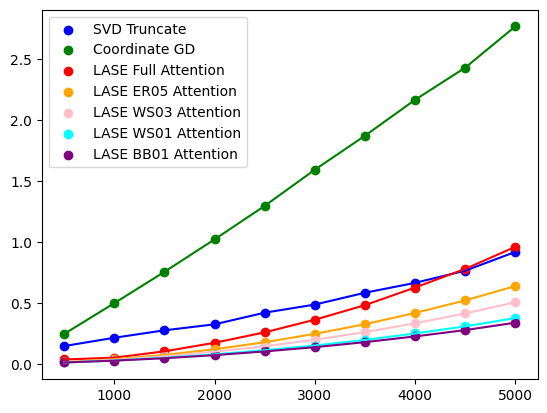

In [13]:
with open('./results/svd_performance.pkl', 'rb') as f:
    svd_exec_time = pickle.load(f)

with open('./results/coord_gd_performance.pkl', 'rb') as f:
    cgd_exec_time = pickle.load(f)

with open('./results/lase_full_performance.pkl', 'rb') as f:
    lase_full_exec_time = pickle.load(f)
    
with open('./results/lase_ER05_performance.pkl', 'rb') as f:
    lase_ER05_exec_time = pickle.load(f)
        
with open('./results/lase_WS03_performance.pkl', 'rb') as f:
    lase_WS03_exec_time = pickle.load(f)

with open('./results/lase_WS01_performance.pkl', 'rb') as f:
    lase_WS01_exec_time = pickle.load(f)

with open('./results/lase_BB01_performance.pkl', 'rb') as f:
    lase_BB01_exec_time = pickle.load(f) 

nodes = np.arange(5,55,5)*100

plt.figure()
plt.scatter(nodes, svd_exec_time[:,0], c ='blue', label = 'SVD Truncate')
plt.plot(nodes, svd_exec_time[:,0], c ='blue')
plt.scatter(nodes, cgd_exec_time[:,0], c ='green', label = 'Coordinate GD')
plt.plot(nodes, cgd_exec_time[:,0], c ='green')
plt.scatter(nodes, lase_full_exec_time[:,0], c ='red', label = 'LASE Full Attention')
plt.plot(nodes, lase_full_exec_time[:,0], c ='red')
plt.scatter(nodes, lase_ER05_exec_time[:,0], c ='orange', label = 'LASE ER05 Attention')
plt.plot(nodes, lase_ER05_exec_time[:,0], c ='orange')
plt.scatter(nodes, lase_WS03_exec_time[:,0], c ='pink', label = 'LASE WS03 Attention')
plt.plot(nodes, lase_WS03_exec_time[:,0], c ='pink')
plt.scatter(nodes, lase_WS01_exec_time[:,0], c ='cyan', label = 'LASE WS01 Attention')
plt.plot(nodes, lase_WS01_exec_time[:,0], c ='cyan')
plt.scatter(nodes, lase_BB01_exec_time[:,0], c ='purple', label = 'LASE BB01 Attention')
plt.plot(nodes, lase_BB01_exec_time[:,0], c ='purple')
plt.legend()
plt.show()

In [20]:
# print(svd_exec_time[[1,3,5,7,9]])
# print(cgd_exec_time[[1,3,5,7,9]])
# print(lase_full_exec_time[[1,3,5,7,9]])
# # print(lase_ER05_exec_time)
# print(lase_WS03_exec_time[[1,3,5,7,9]])
print(lase_WS01_exec_time[[1,3,5,7,9]])
print(lase_BB01_exec_time[[1,3,5,7,9]])

[[3.06406168e-02 3.56710083e-05]
 [8.11430984e-02 3.45446802e-05]
 [1.53685158e-01 2.02579652e-04]
 [2.52267307e-01 1.17025368e-04]
 [3.78120940e-01 6.09728637e-05]]
[[2.97844848e-02 2.58745809e-05]
 [7.47127941e-02 3.67122971e-05]
 [1.39945899e-01 9.50751745e-05]
 [2.28115818e-01 8.96932867e-05]
 [3.40393000e-01 1.24653867e-04]]


In [6]:
lase_BB01_exec_time[9,0]/lase_full_exec_time[9,0]

0.3542025208903087

In [7]:
lase_full_exec_time[9,0]/lase_BB01_exec_time[9,0]

2.823243599414374

In [8]:
cgd_exec_time[9,0]/lase_BB01_exec_time[9,0]

8.126036033507559

In [9]:
svd_exec_time[9,0] / lase_BB01_exec_time[9,0]

1.6586467835619363